In [1]:
# %load Imported_data_and_properties.py
# Imported_data_and_eq uploads all relevet data entries from csv files, to define the variables needed for later calculations

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

#Creating a dict with particle types as keys, and experiment iterations a a list of directories:
## Arranging trajectory file folders to excerpt data from
folders_directory_list = sorted(glob.glob('Data/*'))[1:]      #lst of all Traj file folders, without the index file
## Inserting directories to the iterations to the dict
folders_dict={}
for folder in folders_directory_list:
    fldr_name=folder.rsplit("\\")[-1]
    folders_dict[fldr_name] = glob.glob(folder + '/*csv')

In [2]:
# Uploading data from a file (for now I'm testing how it works on a single file):
data = pd.read_csv(folders_dict["Data/TrajP1"][0])

###info that's not in the Traj files
g = 9.81                                         # gravitational acceleration [m/s2]
Xs = 0.037                                       # upper limit of the interface (start) [m]
Xe = 0.05                                        # bottom limit of the interface (exit) [m]
h=Xe-Xs                                          # interface thickness [m]
rho1= 976                                        # density top layer [kg/m3]
rho2 = 1025                                      # density bottom layer [kg/m3]
lam = 0.35                                       # hyperbolic function constructive param used to simulate density profile [-]
# func constructing the density profile of the whole tank [kg/m3]
def rho(X): return rho2 - 0.5 * (rho2 - rho1) * (1 - np.tanh(X - (Xe + Xs) / (2 * lam * h)))
nu1 = 1.43e-6                                    # kinematic viscosity of the top layer [m2/s]
nu2 = 1.012e-6                                   # kinematic viscosity of the bottom layer [m2/s]

#loc info acc to index file in Data (minus 2 lines from what's listed)
###general data:
X = np.array(data.iloc[1])                       # the bead’s position as a func of t, initialized at the top of the tank. [m]
t_history = np.array(data.iloc[5])                       # starts from 0 at the top of the tank 'till end of measurements [s]
t_e = data.iloc[5,-1]                            # tot time of the iteration [s]
Vp_file = np.array(data.iloc[3])                 # particle velocity as calculated in the mat files [m/s]
def F_drg(Re): return 0.00064 * Re ** 1.44       # drag force as a func. of Re, derived from direct measuring of Vterminal in constant density environment [N]
def Re(V): return V*d/nu1                        # returns momentery Reynolds num acc to viscosity of the top layer [-]
Vt1 = data.iloc[15,0]                              # terminal velocity in the top layer [m/s]

###sphere properties:
d = data.iloc[7,0]                               # sphere's diameter [m]
rhop = data.iloc[8,0]                            # sphere's density [kg/m3]
def Vol_p(d): return np.pi * d ** 3 / 6          # sphere's volume [m3]
def m(d, rhop): return rhop * Vol_p(d)           # sphere's mass [kg]
m = m(d,rhop)

###drift volume properties:
omega = 0.15                                     # distance from the sphere [cm]
z = 4.792e-5                                     # entrained fluid’s mass [Kg]. Can be shifted to fit data
beta0 = 0.06                                     # diffusivity due to mass concentrations, set to same order as diffusivity of salt in water [1/s]
beta_trb = 0.94                                  # turbulent diffusivity [1/cm]
def beta(Vp): return beta0 + beta_trb * abs(Vp)  # total diffusivity coefficient

In [3]:
def find_nearest_time(t_history,t):
    absolute_val_array = np.abs(t_history - t)
    smallest_difference_index = absolute_val_array.argmin()
    # closest_element = t_history[smallest_difference_index]
    return smallest_difference_index

In [4]:
# %load Velocity_calc_by_model.py

from scipy.integrate import odeint
# from Imported_data_and_properties import *


# function that returns d2X_dt2, drhod_dt, deta_dt
def model(z,t,X):
    
    dX_dt = z[0]
    rhod = z[1]
    eta = z[2]
    
    # print(z)
    
    # find the position in vector X based on the local time t and the known vector t_history (see above)
    # maybe it's better to use interpolation above to create a function from which we 
    # can sample the position in continuous way
    ind = find_nearest_time(t_history,t)
    x = X[ind]
    
    # print(t,x)
    
    # print(Re(2*dX_dt - eta))
    # print(F_drg(Re(2*dX_dt - eta)))
    # print(g*(rhop-rho(x))/rhop)

    d2X_dt2 = g*(rhop-rho(x))/rhop + F_drg(Re(2*dX_dt - eta))
    drhod_dt = beta(dX_dt)*(rho(x) - rhod)
    deta_dt = g*(rho(x - omega) - rhod)/rhod + F_drg(Re(eta - dX_dt))
    

    return [d2X_dt2, drhod_dt, deta_dt]

#initial conditions
z0=[Vt1, rho(0), Vt1]

#defining the time steps for the solution
t_tot=np.linspace(0, t_e, 100)      #generate a solution at 101 evenly spaced samples in the interval 0 <= t <= t_e

sol = odeint(model, z0, t_tot,args=(X,))  #contains the a solution for dX_dt, rhod, eta 


[1.37399373e-02 9.76000000e+02 1.37399373e-02]
0.0 0.00128723404255319
[1.37481501e-02 9.76000000e+02 1.37399373e-02]
1.3000345327678248e-05 0.00128723404255319
[1.37481504e-02 9.76000000e+02            nan]
1.3000345327678248e-05 0.00128723404255319
[         nan 976.00000024          nan]
2.6000690655356495e-05 0.00128723404255319
[nan nan nan]
0.13002945396743784 0.00128723404255319
[nan nan nan]
0.26003290724422035 0.00128723404255319
[nan nan nan]
0.3900363605210028 0.00128723404255319
[nan nan nan]
1.6900708932888275 0.00140425531914894
[nan nan nan]
2.990105426056652 0.0015027995520716698
[nan nan nan]
4.290139958824477 0.00154591265397536
[nan nan nan]
17.290485286502722 0.00198936170212766


<ipython-input-2-3d517c97b42f>:23: RuntimeWarning: invalid value encountered in double_scalars
  def F_drg(Re): return 0.00064 * Re ** 1.44       # drag force as a func. of Re, derived from direct measuring of Vterminal in constant density environment [N]


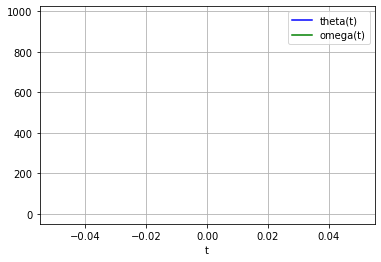

In [5]:
import matplotlib.pyplot as plt
plt.plot(t_tot, sol[:, 0], 'b', label='theta(t)')
plt.plot(t_tot, sol[:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [6]:
sol

array([[1.37399373e-02, 9.76000000e+02, 1.37399373e-02],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,        